# Snowmageddon '19
Or is it Snopocalpyse '19?

February 15, 2019  
David Shean

## Objectives
* Explore spatial relationships in time series of field observations
* Learn about dynamic data fetching, ingestion into Pandas/GeoPandas and basic spatial analysis
* Explore some simple interpolation routines
* Explore some fundamental concepts and metrics for snow science

## Read a bit about SNOTEL data for the Western U.S.

https://www.wcc.nrcs.usda.gov/snow/

This is actually a nice web interface, with some advanced querying and interactive visualization.  You can also download formatted ASCII files (csv) for analysis.  This is great for one-time projects, but it's nice to have [deterministic code](https://en.wikipedia.org/wiki/Deterministic_system) that can be updated as new data appear, without manual steps.  That's what we're going to do here.

### About SNOTEL sites and data:
* https://www.wcc.nrcs.usda.gov/about/mon_automate.html
* https://www.wcc.nrcs.usda.gov/snotel/snotel_sensors.html
* https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=27630.wba

## CUAHSI WOF server and `ulmo` for Python queries

We are going to use a server set up by CUAHSI to serve the SNOTEL data, using a standardized database storage format and query structure.  You don't need to worry about this, but please quickly review the following:
* http://hiscentral.cuahsi.org/pub_network.aspx?n=241 
* http://his.cuahsi.org/wofws.html

### Acronym soup
* SNOTEL = Snow Telemetry
* CUAHSI = Consortium of Universities for the Advancement of Hydrologic Science, Inc
* WOF = WaterOneFlow
* WSDL = Web Services Description Language
* USDA = United States Department of Agriculture
* NRCS = National Resources Conservation Service
* AWDB = Air-Water Database

### Python options

There are a few packages out there that offer convenience functions to query the online SNOTEL databases and unpack the results.  You can also write your own queries using the Python `requests` module and some built-in XML parsing libraries
* climata (https://pypi.org/project/climata/) - last commit Sept 2017 (not a good sign)
* ulmo (https://github.com/ulmo-dev/ulmo) - last commit a Feb 2019 (but not well maintained, and will be superseded soon)

Hopefully not overwhelming amount of information - let's just go with ulmo for now.  I've done most of the work to prepare functions for querying and processing the data.  Once you wrap your head around all of the acronyms, it's pretty simple, basically running a few functions here: https://ulmo.readthedocs.io/en/latest/api.html#ulmo-cuahsi-wof

I did discover a bug on the CUAHSI server side with the hourly SNOTEL data.  This works fine through climata and the https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL source), but I don't have time to redo everything with climata.  

So we're just going to use ulmo with daily data for this exercise, but please feel free to experiment with my code, with climata, or parsing files you download via the web interface.

Note that support for ulmo is ending, and will be superseded by another package called Quest (https://github.com/ulmo-dev/ulmo/issues/161)

### Important ulmo installation note

The current conda-forge build of ulmo requires an older version of pandas.  Also, some commits in the past few weeks fixed some bugs.  I've been told there will be a new conda-forge build next week, but we have geospatial data that needs analysis now!  So we're going to use a development version of ulmo, straight from the github source.  This is a good exercise, and will show you how to grab source code directly from github for local use and development.

To install:
1. Open a terminal on the Jupyterhub and `git clone https://github.com/ulmo-dev/ulmo.git` somewhere in your home directory
2. `cd ulmo`
3. `pip install -e .` (this will run a "developer" install, which means you can modify the source code and use updated versions in real-time)
4. Restart the kernel in your notebook and you should be all set to `import ulmo` without issue
5. Note that if your Jupyterlab server restarts, you may need to repeat #3

In [1]:
import ulmo

## Set up notebook plotting style

In [2]:
#%matplotlib widget
%matplotlib inline

## Import necessary modules

In [3]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
plt.rcParams['figure.figsize'] = [10, 8]

## CUAHSI WOF server information

In [4]:
#http://his.cuahsi.org/wofws.html
wsdlurl = 'http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
#wsdlurl = "http://worldwater.byu.edu/interactive/snotel/services/index.php/cuahsi_1_1.asmx?WSDL"  # WOF 1.1

## Get information about all of the SNOTEL sites from the server

In [5]:
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

## Take a moment to inspect the output

* What is the `type`?  Don't just put the output of the command - what is this thing and how are the data structured, in your own words?
* What happens when you print?

### All of the data is arranged in a dictionary output. Each SNOTEL point has multiple features including a code, elevation (containing both latitude and longitude coordinates), location, name, and network. It almost looks like a GeoJSON file, but I think this would require features like "geometry", "location", etc.

In [6]:
# commented out for the moment to save screen space
#sites

## Store as a Pandas DataFrame called `sites_df`
* See the `from_dict` function
* Use `orient` option so the sites comprise the DataFrame index, with columns for 'name', 'elevation_m', etc

In [7]:
sites_df = pd.DataFrame.from_dict(sites,orient='index')
sites_df.head()

,code,name,network,location,elevation_m
SNOTEL:1000_OR_SNTL,1000_OR_SNTL,Annie Springs,SNOTEL,"{'latitude': '42.8701', 'longitude': '-122.1652'}",1831.8
SNOTEL:1001_AK_SNTL,1001_AK_SNTL,Long Lake,SNOTEL,"{'latitude': '58.186', 'longitude': '-133.8322'}",259.1
SNOTEL:1002_AK_SNTL,1002_AK_SNTL,Point Mackenzie,SNOTEL,"{'latitude': '61.3898', 'longitude': '-150.0267'}",76.2
SNOTEL:1003_AK_SNTL,1003_AK_SNTL,Mcneil Canyon,SNOTEL,"{'latitude': '59.7443', 'longitude': '-151.2513'}",402.3
SNOTEL:1004_WA_SNTL,1004_WA_SNTL,Epa Waterhole Can,SNOTEL,"{'latitude': '48.5667', 'longitude': '-123.7'}",1524


## Clean up the DataFrame and prepare Point geometry objects
* Hint: we did most of this with the GLAS data conversion to GeoPandas
* Convert 'location' column (contains dictionary with 'latitude' and 'longitude' values) to Shapely Points
* Store as a new 'geometry' column
* Drop the 'location' column, as this is no longer needed
* Update the dtype of the 'elevation_m' column to float

In [8]:
sites_df['geometry'] = [Point(float(loc['longitude']), float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})

## Create a GeoDataFrame named `sites_gdf` with appropriate crs definition

* Take a moment to familiarize yourself with the DataFrame structure and different fields.
* Note that the index is a set of strings with format 'SNOTEL:1000_OR_SNTL'
* Note the number of records

In [9]:
sites_gdf = gpd.GeoDataFrame(sites_df,geometry=sites_df['geometry'],\
                        crs={'init':'epsg:4326'})
sites_gdf.head()
# 5 records (including the geometry) for each SNOTEL index (site)

,code,name,network,elevation_m,geometry
SNOTEL:1000_OR_SNTL,1000_OR_SNTL,Annie Springs,SNOTEL,1831.8,POINT (-122.1652 42.8701)
SNOTEL:1001_AK_SNTL,1001_AK_SNTL,Long Lake,SNOTEL,259.1,POINT (-133.8322 58.186)
SNOTEL:1002_AK_SNTL,1002_AK_SNTL,Point Mackenzie,SNOTEL,76.2,POINT (-150.0267 61.3898)
SNOTEL:1003_AK_SNTL,1003_AK_SNTL,Mcneil Canyon,SNOTEL,402.3,POINT (-151.2513 59.7443)
SNOTEL:1004_WA_SNTL,1004_WA_SNTL,Epa Waterhole Can,SNOTEL,1524.0,POINT (-123.7 48.5667)


## Create a scatterplot showing elevation values of all sites

Text(0.5, 1.0, 'SNOTEL elevation [m]')

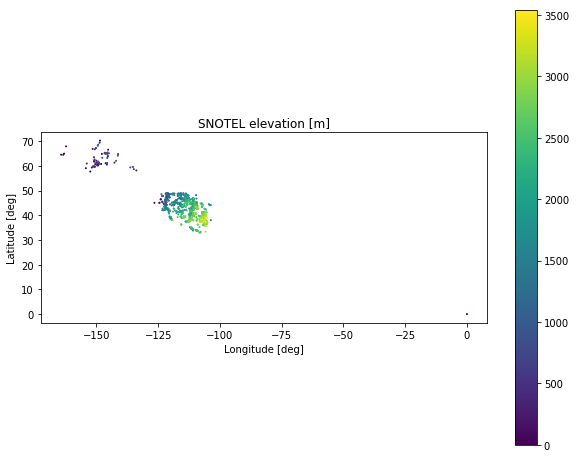

In [10]:
ax = sites_gdf.plot(c=sites_gdf['elevation_m'],legend=False,\
                   markersize=1)
c = plt.colorbar(ax.collections[0],ax=ax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')
plt.title('SNOTEL elevation [m]')

## Exclude any records with incorrect coordinates of (0,0)
* Note the updated number of records

In [11]:
# all sites with y-coordinate 0 had x-coordinate of zero
sites_gdf = sites_gdf[sites_gdf['geometry'].x != 0]
sites_gdf.count()

code           930
name           930
network        930
elevation_m    930
geometry       930
dtype: int64

## Exclude the Alaska (AK) points to isolate points over Western U.S.
* Can use a spatial filter (see GeoPandas cx indexer functionality) or remove points where the site name contains 'AK'
* Note the number of records

In [12]:
sites_gdf = sites_gdf[~sites_gdf.index.str.contains('AK')]
sites_gdf.count()

code           865
name           865
network        865
elevation_m    865
geometry       865
dtype: int64

## Update your scatterplot as sanity check
* Should look something like the Western U.S.

Text(0.5, 1.0, 'SNOTEL elevation [m]')

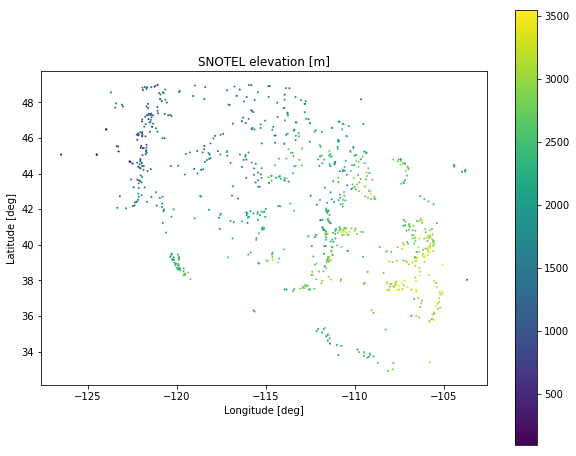

In [13]:
ax = sites_gdf.plot(c=sites_gdf['elevation_m'],legend=False,\
                   markersize=1)
c = plt.colorbar(ax.collections[0],ax=ax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')
plt.title('SNOTEL elevation [m]')

## Create an interactive plot with basemap using folium

We haven't discussed as a class yet, but this is a simple, effective interactive visualization package (alternative to matplotlib)

See the example here: https://python-visualization.github.io/folium/docs-v0.6.0/quickstart.html

For your plot:
* Compute the centroid of the SNOTEL sites (remember GeoPandas `unary_union`)
* Create a map object centered on this centroid
    * Use the 'Stamen Terrain' basemap layer
    * Experiment with `zoom_start` level to find a good extent
* Export your GeoDataframe using `to_json()`, then load all features using `folium.features.GeoJson`
* Add the points to the map

Take a moment to explore this interactive map interface.

In [14]:
c = sites_gdf.unary_union.centroid
lat = c.y
lon = c.x

In [15]:
import folium
from folium.plugins import MarkerCluster
m = folium.Map(location=[lat, lon], tiles='Stamen Terrain', zoom_start=5)
points = folium.features.GeoJson(sites_gdf.to_json())
m.add_child(points)
m

## Extra Credit (if you have time after finishing the lab, and/or are interested in exploring folium)

* Create an interactive `folium` map with a MarkerCluster that displays the SNOTEL site name and/or ID
* This example is likely useful: https://ocefpaf.github.io/python4oceanographers/blog/2015/12/14/geopandas_folium/

In [16]:
import folium
from folium.plugins import MarkerCluster
m = folium.Map(location=[42.2805, -113.2796], tiles='Stamen Terrain', zoom_start=5)
#Create clustered map with popups
locations, popups = [], []
for idx,row in sites_gdf.iterrows():
    locations.append([row['geometry'].y, row['geometry'].x])
    popups.append(idx)
t = folium.FeatureGroup(name='SNOTEL')
t.add_child(MarkerCluster(locations=locations, popups=popups))
m.add_child(t)
m

## Create a histogram of SNOTEL site elevations
* What is the highest SNOTEL site in the Western U.S.?
* Do these elevations seem to provide a good sample of elevations where snow accumulates? (just think about this for a minute, I'm hoping we can revisit when we start working with DEM and climate reanalysis data)

Text(0.5, 0, 'Elevation [m]')

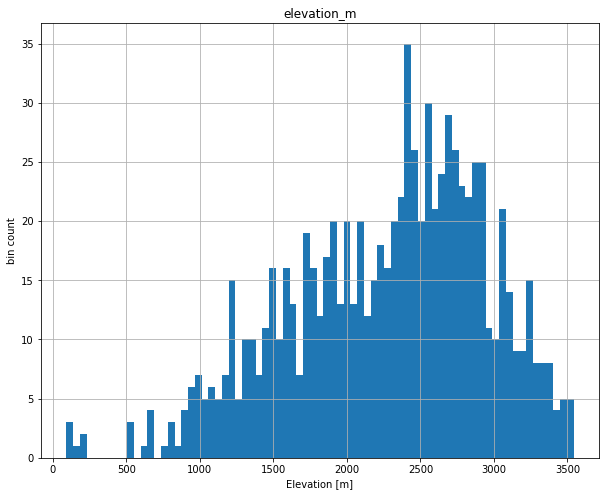

In [17]:
sites_gdf.hist(column='elevation_m',bins=75)
plt.ylabel('bin count')
plt.xlabel('Elevation [m]')

In [18]:
sites_gdf.name[sites_gdf.elevation_m == sites_gdf.elevation_m.max()].iloc[0]

'Grayback'

### Overall, I thought the distribution of elevations for the SNOTEL sites was decent. From the distribution and the mapping in the previous steps, you can see that SNOTEL stations favor mountainous locations where snow is more likely and coverage is longer in duration. However, it seems to miss some key locations (like central Washington and Southwestern Wyoming) where snow occurs, but is more transient. Therefore, extrapolation and assimilation using points in the mountains may be biasing snow in flat areas.

## Reproject the sites GeoDataFrame to an equal-area projection
* Can use the same projection from the GLAS example, or recompute based on bounds and center of SNOTEL sites

In [19]:
sites_gdf.crs

{'init': 'epsg:4326'}

In [20]:
#sites_gdf.total_bounds
aea_proj='+proj=aea +lat_1=37.31 +lat_2=46.69 +lat_0=42.00 +lon_0=-114.27 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
sites_gdf_proj = sites_gdf.to_crs(aea_proj)

## Create a scatterplot and overlay the state polygons

In [21]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf_proj = states_gdf.to_crs(aea_proj)

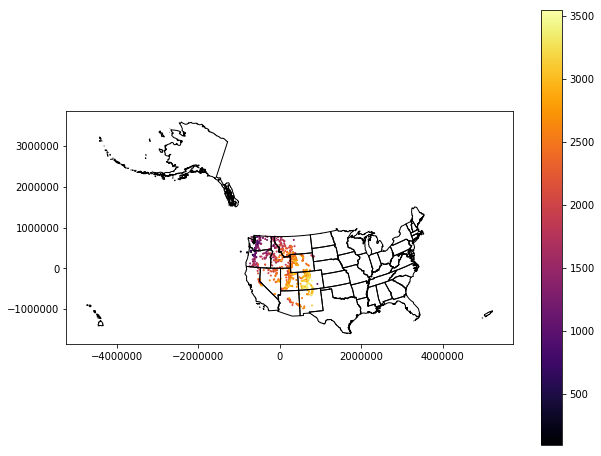

In [22]:
f, ax = plt.subplots()
sites_gdf_proj.plot(ax=ax, column='elevation_m', markersize=1, cmap='inferno', legend=True)
states_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='black')

## Isolate WA sites
* Could do a spatial join with WA polygon, as we did in the GLAS example
* But probably easiest to filter records with 'WA' in the index
    * Note: need to convert the SNOTEL DataFrame index to `str`
    * `contains` might be a nice option
* Sanity check - note number of records and create a quick scatterplot to verify

In [23]:
sites_gdf_proj = sites_gdf_proj[sites_gdf_proj.index.str.contains('WA')]
sites_gdf_proj.count()

code           84
name           84
network        84
elevation_m    84
geometry       84
dtype: int64

(461755.6794643949, 797349.4115162572)

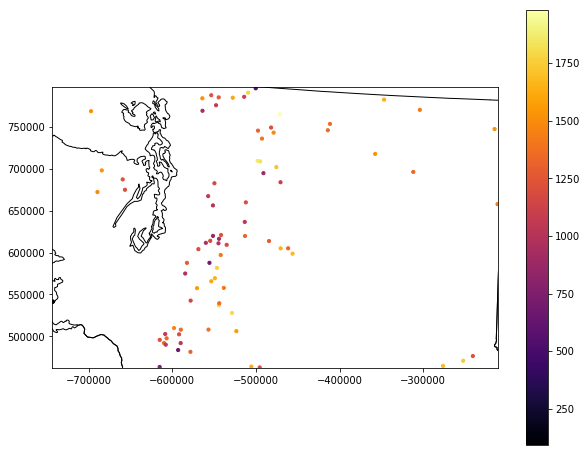

In [24]:
w, s, e, n = sites_gdf_proj.total_bounds
f, ax = plt.subplots()
sites_gdf_proj.plot(ax=ax, column='elevation_m', markersize=10, cmap='inferno', legend=True)
states_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='black')
plt.xlim(w-1000,e+1000)
plt.ylim(s-1000,n+1000)

## Create a histogram plot showing elevation of all SNOTEL sites in Western US and the WA sample
* What do you notice about the WA sample?

Text(0.5, 0, 'Elevation [m]')

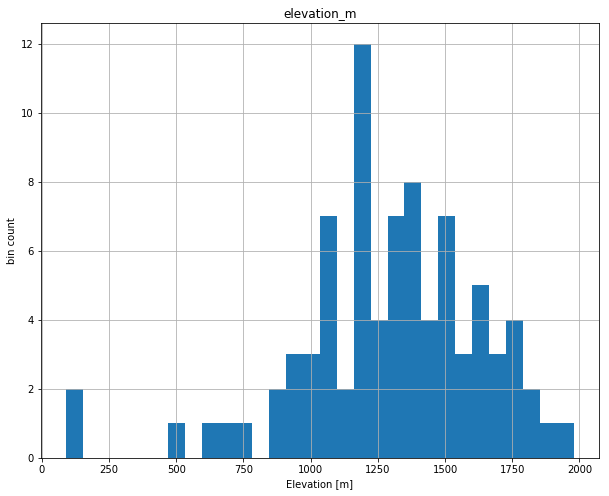

In [25]:
sites_gdf_proj.hist(column='elevation_m',bins=30)
plt.ylabel('bin count')
plt.xlabel('Elevation [m]')

### Although smaller in magnitude, the overall distribution is fairly similar to total distribution seen before. Given the elevation distribution of washington, elevations of < 1000m could be severely misrepresented. However, these elevations are commonly don't receive enough snow to justify the installation and maintanance of a SNOTEL site.

## Identify the highest site in WA
* Assign one to a variable named `sitecode`

In [33]:
#sitecode = sites_gdf_proj.code[sites_gdf_proj.elevation_m == sites_gdf_proj.elevation_m.max()].iloc[0]
sitecode = sites_gdf_proj.code[sites_gdf_proj.name == 'Buckinghorse'].iloc[0]

In [34]:
#sites_gdf_proj


## Query the server for information about this site

In [35]:
site_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecode)

## Inspect the returned information
* Note available data series 

In [36]:
site_info['series'].keys()

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_D', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_D', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_H', 'SNOTEL:PREC_m', 'SNOTEL:PREC_wy', 'SNOTEL:PVPV_H', 'SNOTEL:RHUMV_H', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:SRADV_H', 'SNOTEL:SRADX_H', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TAVG_H', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

## Let's consider the 'SNOTEL:SNWD_D' variable (Daily Snow Depth)
* Assign 'SNOTEL:SNWD_D' to a variable named `variablecode`
* Get some information about the variable
* Note the units, nodata value, etc.

In [37]:
variablecode = 'SNOTEL:SNWD_D'
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

{'code': 'SNWD_D',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'id': None,
 'name': 'Snow depth',
 'no_data_value': '-9999',
 'sample_medium': 'Snow',
 'speciation': 'Not Applicable',
 'time': {'interval': '1',
  'is_regular': True,
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'},
 'value_type': 'Field Observation',
 'vocabulary': 'SNOTEL'}

## Define a function to fetch data
* I've done this for you, but please review the comments and steps to see what is going on under the hood
* You'll probably have to do similar data wrangling for another project at some point in the future

In [38]:
#Get current datetime
today = datetime.today().strftime('%Y-%m-%d')

def fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

## Use this function to get the full 'SNOTEL:SNWD_D' record for the highest station in WA without specifying start and end dates
* Inspect the results
* What are the first and last dates returned?

In [39]:
valSNO = fetch(sitecode)
valSNO.head()
valSNO.tail()
# dates noted in the function print

1107_WA_SNTL SNOTEL:SNWD_D 1950-10-01 2019-03-01


,censor_code,method_code,method_id,qualifiers,quality_control_level_code,source_code,value
datetime,,,,,,,
2019-02-25 00:00:00+00:00,nc,0,0,E,1,1,102
2019-02-26 00:00:00+00:00,nc,0,0,V,1,1,102
2019-02-27 00:00:00+00:00,nc,0,0,V,1,1,101
2019-02-28 00:00:00+00:00,nc,0,0,E,1,1,100
2019-03-01 00:00:00+00:00,nc,0,0,V,1,1,101


## Create a quick plot to view the time series
* What do you notice?

Text(0, 0.5, 'Snow depth [in]')

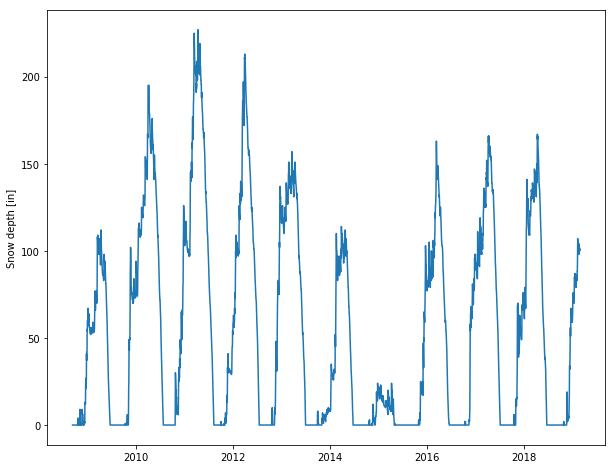

In [40]:
plt.plot(valSNO['value'])
plt.ylabel('Snow depth [in]')

# Get all daily snow depth records for all sites in WA
* Note that this could take some time to run (10-20 min, depending on server load)
    * Progress will be printed out incrementally
    * While you wait, review the remainder of the lab
* Loop through all sites names in the WA GeoDataFrame and fetch
* Store in a dictionary
* Convert the dictionary to a Pandas Dataframe

## Save the DataFrame, so you don't have to download again
* Can use a number of different formats, easiest to use a "pickle": https://www.pythoncentral.io/how-to-pickle-unpickle-tutorial/
* Define a unique filename for the dataset (e.g., `pkl_fn='snotel_wa_snwd_d.pkl'`)
* Write the DataFrame to disk
* Read it to a temporary variable and verify that everything looks good

In [ ]:
pkl_fn = 'snotel_wa_snwd_d_20190215.pkl'
#pkl_fn = variablecode.replace(':','_')+'_'+start_date+'_'+end_date+'.pkl'

In [ ]:
if os.path.exists(pkl_fn):
    wa_dict = pd.read_pickle(pkl_fn)
else:
    #Define an empty dictionary to store returns for each site
    value_dict = {}
    for i, sitecode in enumerate(sites_gdf_proj.index):
        print('%i of %i sites' % (i+1, len(sites_gdf_proj.index)) )
#        out = fetch(sitecode, variablecode, start_date, end_date)
        out = fetch(sitecode)
        if out is not None:
            value_dict[sitecode] = out['value']
    #Convert the dictionary to a DataFrame, automatically handles different datetime ranges (nice!)
    wa_dict = pd.DataFrame.from_dict(value_dict)
    #Write out
    wa_dict.to_pickle(pkl_fn)

## Inspect the DataFrame
* Note structure, number of timestamps, NaNs
* What is the date of the first snow depth measurement in the network?
    * Note that the water equivalent (WTEQ_D) measurements from snow pillows extend much farther back in time, back to the early 1980s, before the ultrasonic snow depth instruments were incorporated across the network.  These are better to use for long-term studies.

In [ ]:
# can also get this by just doing:
# wa_dict.first_valid_index()
wa_dict.apply(lambda series: series.first_valid_index()).min()

## Convert snow depth inches to cm

In [ ]:
wa_dict_cm = wa_dict * 2.54
wa_dict_cm.tail()

## Compute daily difference in snow depth at all stations
* See the `diff` function
* Make sure you specify the axis properly to difference over time (not station to station), and sanity check
* Create plot showing daily accumulation over time with a line for each site
    * Adjusting the ylim appropriately
    * Probably best to turn off the legend in your plot call

In [ ]:
differ = wa_dict_cm.diff(1,0)
plt.plot(differ)
# only show depth accumulation
plt.ylim(0,200)
#just take a slice of data that has good QAQC
plt.xlim(pd.Timestamp(2009,1,1),pd.Timestamp(2017,1,1))

## Interpretation
* When the snow depth increases from one day to the next, what happened?
* When the snow depth decreases from one day to the next, what happened?  

### When snow depth increases:
#### snow precipitation (most likely)
#### drifting snow
#### tree sloughing (not likely since SNOTEL sites are in the open.
### When snow depth decreases:
#### snow compaction
#### snow melt
#### rain precip
#### canopy drip
### Given the acoustic sensors, significant random error (in both directions) is likely

## How might you filter these differences to remove artifacts and outliers?
* If a single station shows an increase of 2 m, but all others show a decrease, is that realistic?
* Do you think you can confidently identify large snow accumulation events using these difference values?
* Could likely design a filter to remove outliers using mean +/- (3 * std) for all stations
    * Maybe come back to this if you have time later, for now, just note the presence of measurement errors
    
## For now, let's aggregate across all stations
* Create a plot showing the median difference values across all stations for each day (again, careful about which axis along which you're computing the median)
* You may need to adjust the ylim

### Since the SNOTELS are spread out across different weather patterns for a given event, it is tough to say with absolute certainty that a value is erroneous from other stations. However, for obvious errors, you could exclude points based on a quantile (upper 99%, or something similar) for that date.

In [ ]:
differ.tail()
meds = wa_dict_cm.diff(24,0).median(axis=1)
plt.plot(meds)

## Create a similar plot, but limit to records since Jan 1, 2019
* Can you identify the big snow events?  Does this correlate with your experience here in Seattle during Snowmageddon '19?
    * Can also further limit x-axis to Feb 1, 2019

In [ ]:
plt.plot(meds)
plt.xlim(pd.Timestamp(2019,1,1),wa_dict_cm.index[-1])
plt.ylim(-10,80)
plt.ylabel('Snow accumulation [cm]')

### There appeared to be a series of large accumulation events occuring between February 7th and February 10th. This seems in line with the Seattle SnowMageddon

## Get the count of valid records (not NaN) available for each station
* Create a bar plot, sorted from shortest to longest record
* What is the longest record available for SNWD_D?

In [ ]:
plt.bar(wa_dict_cm.columns.values,wa_dict_cm.count().sort_values())
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Number of NaNs between 1950-10-01 and 2019-02-22')

## Add the count dataseries as a new column in the WA sites GeoDataframe
* Should be easy, let Pandas do the work to match site index values
* Verify your site DataFrame now has a count column

In [ ]:
sites_gdf_proj['counts'] = wa_dict_cm.count()
sites_gdf_proj.head()

## Add a column for the long-term max snow depth on record for each site
* Might need to be careful about measurement errors here - maybe look at values and filter obvious outliers

In [ ]:
sites_gdf_proj['max'] = wa_dict_cm.quantile(0.99)
plt.plot(wa_dict_cm.max(),label='maximum')
plt.plot(sites_gdf_proj['max'],label='99% quantile')
plt.legend()
plt.xticks(rotation='vertical')
plt.ylabel('Long term maximum snow depth')

## Add a column for the daily difference (snow accumulation) at all sites for Feb 12
* Note, you may need to use `mydataframe.loc[pd.Timestamp('YYYY-MM-DD')]`

In [ ]:
sites_gdf_proj['snowPocAccum'] = differ.loc[pd.Timestamp('2019-02-12')]

## Add a column for the snow depth on the most recent day in the record
* Use the last relative index value (should be today, or whenever you ran the query)
* Note that the index is not a string, it is a Pandas Timestamp object: `pd.Timestamp('2019-02-06 00:00:00')`

In [ ]:
sites_gdf_proj['snowToday'] = wa_dict_cm.loc[wa_dict_cm.index[-1]]

## Extra Credit: See if you can add a column for total snow accumulation in February 2019 at each site
* Use a `slice` object of pandas Timestamps
* You'll need to isolate days with positive snow accumulation from days where no new snow fell
*

## Extra Credit: Add a column for the long-term mean snow depth at each site
* Note: to do this properly, probably want to remove any values near 0 (no snow on the ground) before computing the mean

## Create some scatterplots to review these metrics
* Hint: remove NaN records on the fly before plotting - see the `dropna()` method
    * Best to apply after isolating the column you want to plot, consider `mydataframe[['max', 'geometry]].dropna().plot(column='max', ...)`
* See if you can create a figure with multiple subplots, and then 

In [ ]:
import contextily as ctx
new = sites_gdf_proj.to_crs(epsg=3857)
new.crs

In [ ]:
w, s, e, n = new.total_bounds
%time img, ext = ctx.bounds2img(w, s, e, n, 8, ll=False)
var = ['counts','max','snowPocAccum','snowToday']
f = plt.figure()
for i in range(0,4):
    ax = plt.subplot(2,2,i+1)
    ax.imshow(img, extent = ext,alpha=0.7)
    new[[var[i], 'geometry']].dropna().plot(column=var[i],ax=ax,legend=True)
    plt.title(var[i])


## Can you identify the SNOTEL site with:
* Greatest long-term maximum snow depth
* Greatest accumulation on February 12
    * Where should I go skiing this weekend if I like deep snow?  Mt. Baker or Mt. Rainier?
* Extra Credit: Greatest Feb 2019 accumulation

In [ ]:
# greatest long term maximum
print(new['name'][new['max'].idxmax()])
# greatest feb 12 accum
print(new['name'][new['snowPocAccum'].idxmax()])

### Most of the deepest snow was south towards Mt. Rainier, with an impressive front going up 1-90 corridor

## Extra Credit: Compute and plot at least one additional metric of interest for snow depth at the WA sites
* Consider aggregation over time and/or space
* Provide brief analysis and interpretation

## Snow depth vs. elevation analysis
* Let's look at snow depth across WA on the most recent day in the record
* Create a quick scatterplot of elevation vs. snow depth for all sites on this day
* Do you see a relationship?  

In [ ]:
plt.scatter(new['elevation_m'],new['snowToday'])
plt.ylabel('Snow depth [cm]')
plt.xlabel('Elevation [m]')

### Although there may be a relationship here, it is not very defensible. A multivariate regression including other meteorological and terrain features may be more successful.

## Extra Credit: Fit a simple linear regression to the snow depth vs. elevation data
* How good is your fit?
* Compare accumulation vs elevation for a recent storm event with abundant lowland snow (e.g., Feb 11) with another more typical accumulation event (where low elevations receive rain and mountains receive snow)

## Interpolate recent accumulation pattern for the full WA state domain
* Note that you wouldn't want to do this in practice for such a sparse sample, but let's explore for purposes of illustration (and to get us thinking about continuous gridded data (rasters!))
* We'll use the `scipy.interpolate.griddata` function here, using 'nearest' to start, and `scipy.interpolate.Rbf`

In [ ]:
import numpy as np
import scipy.interpolate

## Specify the column name of variable to interpolate

In [ ]:
var = 'snowPocAccum'

## Review the comments/code in the following cells, then run

In [ ]:
#Extract the column and geometry, drop NaNs
sites_gdf_wa_dropna = sites_gdf_proj[[var,'geometry']].dropna()
#Pull out (x,y,val)
x = sites_gdf_wa_dropna.geometry.x
y = sites_gdf_wa_dropna.geometry.y
z = sites_gdf_wa_dropna[var]
#Get min and max values
zlim = (z.min(), z.max())

In [ ]:
#Compute the spatial extent of the points - we will interpolate across this domain
bounds = sites_gdf_wa_dropna.total_bounds
#Spatial interpolation step of 1 km
dx,dy = (1000,1000)
#Create 1D arrays of grid cell coordinates in the x and y directions
xi = np.arange(np.floor(bounds[0]), np.ceil(bounds[2]),dx)
yi = np.arange(np.floor(bounds[1]), np.ceil(bounds[3]),dy)

In [ ]:
#Function that will plot the interpolated grid, overlaying original values
def plotinterp(zi):
    f, ax = plt.subplots()
    #Define extent of the interpolated grid in projected coordinate system, using matplotlib extent format (left, right, bottom, top)
    mpl_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
    #Plot the interpolated grid, providing known extent
    #Note: need the [::-1] to flip the grid in the y direction
    ax.imshow(zi[::-1,], cmap='inferno', extent=mpl_extent, clim=zlim)
    #Overlay the original point values with the same color ramp
    sites_gdf_proj.plot(ax=ax, column=var, cmap='inferno', markersize=30, edgecolor='0.5', vmin=zlim[0], vmax=zlim[1], legend=True)
    #Make sure aspect is equal
    ax.set_aspect('equal')

In [ ]:
#Create 2D grids from the xi and yi grid cell coordinates
xx, yy = np.meshgrid(xi, yi)
#Interpolate values using griddata
zi = scipy.interpolate.griddata((x,y), z, (xx, yy), method='nearest')
plotinterp(zi)

In [ ]:
#Use Radial basis function interpolation
f = scipy.interpolate.Rbf(x,y,z, function='linear')
zi = f(xx, yy)
plotinterp(zi)

In [ ]:
#Create 2D grids from the xi and yi grid cell coordinates
xx, yy = np.meshgrid(xi, yi)
#Interpolate values using griddata
zi = scipy.interpolate.griddata((x,y), z, (xx, yy), method='linear')
plotinterp(zi)

In [ ]:
#Create 2D grids from the xi and yi grid cell coordinates
xx, yy = np.meshgrid(xi, yi)
#Interpolate values using griddata
zi = scipy.interpolate.griddata((x,y), z, (xx, yy), method='cubic')
plotinterp(zi)

In [ ]:
#Use Radial basis function interpolation
f = scipy.interpolate.Rbf(x,y,z, function='gaussian')
zi = f(xx, yy)
plotinterp(zi)

In [ ]:
#Use Radial basis function interpolation
f = scipy.interpolate.Rbf(x,y,z, function='thin_plate')
zi = f(xx, yy)
plotinterp(zi)

## Explore this a bit
* Try a few different interpolation methods for griddata and Rbf
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
* Extra Credit: Play around with some other unstructured data interpolation methods
    * https://docs.scipy.org/doc/scipy/reference/interpolate.html#multivariate-interpolation
    * Others outside of scipy.interpolate

# Extra credit (or, some additional ideas to explore)

If you have some time (or curiosity), feel free to explore some of these, or define your own questions.  This is a really rich dataset to explore, and those of you interested in snow may have some cool ideas.

1. Compute snow depth statistics across all sites grouping by Water Year (or by month/day range where snow is typically present)
2. Compute long-term median snowdepth for each day of the year, how does 2019 compare (percent of long-term median)
4. Identify date of first major snow accumulation event each year, date of max snow depth, date of snow disappearance - any evolution over time?
5. Split sites into elevation bands and analyze various metrics
6. Explore other interpolation methods for sparse data
7. Create an animated map of daily accumulation in WA for the past two weeks
8. Look at other variables for the SNOTEL sites (e.g., snow water equivalent, temperature data)
    * Note that WTEQ_D time series begin much earlier than SNWD_D
9. Create maps of snow density for WA using WTEQ_D and SNWD_D
10. Rerun some of your SNWD_D analysis for all SNOTEL stations across the Western U.S.